<a href="https://colab.research.google.com/github/maayanb578/Workout_Classification_MobileNet/blob/main/Workout_Classification_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import deque
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import MobileNet


from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
# hyperparameter
height = 256
width = 256
channels = 3
batch_size = 64
img_shape = (height, width, channels)
img_size = (height, width)

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maayanbitan","key":"287fbf58eda02df86fa5b5424175dbee"}'}

In [13]:
!chmod 600 /root/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [14]:
!pwd

/content


In [15]:
DATA_DIR = '/content/gdrive/MyDrive/workout_exercises_recognition/workoutexercises-dataset_images'

train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                       labels = 'inferred',
                                                       label_mode = 'categorical',
                                                       validation_split = 0.1,
                                                       subset = 'training',
                                                       image_size = img_size,
                                                       shuffle = True,
                                                       batch_size = batch_size,
                                                       seed = 127
                                                      )

val_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                     labels = 'inferred',
                                                     label_mode = 'categorical',
                                                     validation_split = 0.1,
                                                     subset = 'validation',
                                                     image_size = img_size,
                                                     shuffle = True,
                                                     batch_size = batch_size,
                                                     seed = 127
                                                    )

labels = train_ds.class_names
print(labels)

with open('workout_label.txt', 'w') as f:
    for workout_class in labels:
        f.write(f'{workout_class}\n')

Found 1942 files belonging to 8 classes.
Using 1748 files for training.
Found 1942 files belonging to 8 classes.
Using 194 files for validation.
['bench press', 'biceps curl', 'chest fly machine', 'deadlift', 'incline bench press', 'lat pulldown', 'push-up', 'tricep pushdown']


In [16]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.GaussianNoise(10),
                                         tf.keras.layers.RandomContrast(0.1),
                                         tf.keras.layers.RandomZoom(0.2)
                                        ])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

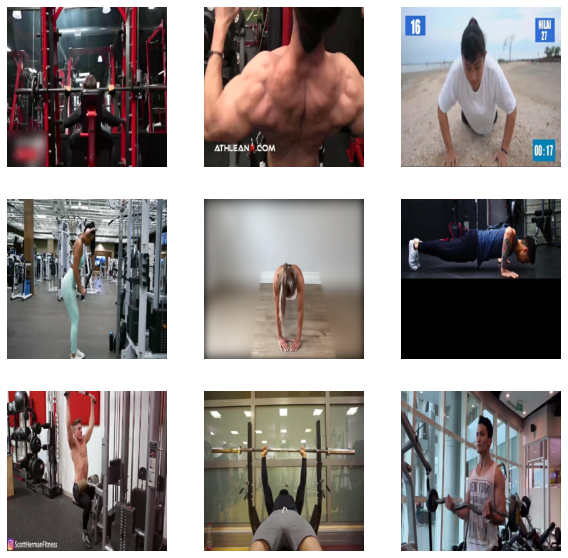

In [17]:
#Defing a function to see images
def show_img(data):
    plt.figure(figsize=(10,10))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(train_ds)

In [18]:
# load pre-trained InceptionV3
#pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')
pre_trained = MobileNet(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

for layer in pre_trained.layers:
    layer.trainable = False

17235968/17225924 [==============================] - 1s 0us/step


In [19]:
x = pre_trained.output
x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
predictions = tf.keras.layers.Dense(len(labels), activation='softmax')(x)

workout_model = tf.keras.models.Model(inputs = pre_trained.input, 
                                      outputs = predictions
                                     )

workout_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy']
                     )

workout_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 128, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 128, 128, 32)     128       
 ation)                                                      

In [20]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', 
                                        patience = 5, 
                                        mode = 'min', 
                                        restore_best_weights = True
                                       )

history = workout_model.fit(train_ds,
                            validation_data = val_ds,
                            epochs = 100,
                            callbacks = [early_stopping_callback]
                           )

Epoch 1/100
28/28 [==============================] - 584s 21s/step - loss: 1.6268 - accuracy: 0.4525 - val_loss: 1.5398 - val_accuracy: 0.5052
Epoch 2/100
28/28 [==============================] - 7s 192ms/step - loss: 0.8208 - accuracy: 0.7946 - val_loss: 1.1152 - val_accuracy: 0.7732
Epoch 3/100
28/28 [==============================] - 7s 196ms/step - loss: 0.4296 - accuracy: 0.8970 - val_loss: 0.8034 - val_accuracy: 0.8608
Epoch 4/100
28/28 [==============================] - 7s 194ms/step - loss: 0.2589 - accuracy: 0.9422 - val_loss: 0.5790 - val_accuracy: 0.8866
Epoch 5/100
28/28 [==============================] - 7s 192ms/step - loss: 0.1829 - accuracy: 0.9605 - val_loss: 0.4365 - val_accuracy: 0.9124
Epoch 6/100
28/28 [==============================] - 7s 191ms/step - loss: 0.1280 - accuracy: 0.9714 - val_loss: 0.3543 - val_accuracy: 0.9227
Epoch 7/100
28/28 [==============================] - 7s 192ms/step - loss: 0.0883 - accuracy: 0.9811 - val_loss: 0.3040 - val_accuracy: 0.9227

4/4 [==============================] - 1s 72ms/step - loss: 0.2152 - accuracy: 0.9433


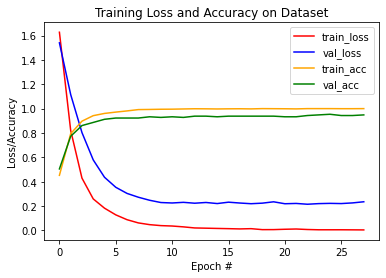

In [21]:
evaluate = workout_model.evaluate(val_ds)

epoch = range(len(history.history["loss"]))
plt.figure()
plt.plot(epoch, history.history['loss'], 'red', label = 'train_loss')
plt.plot(epoch, history.history['val_loss'], 'blue', label = 'val_loss')
plt.plot(epoch, history.history['accuracy'], 'orange', label = 'train_acc')
plt.plot(epoch, history.history['val_accuracy'], 'green', label = 'val_acc')
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [22]:
# Save Model
workout_model.save('workout_model')

# Save .h5 model
workout_model.save('workout_model.h5')

# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model('./workout_model')
tflite_model = converter.convert()

# Save the tflite model
with open('workout_model.tflite', 'wb') as f:
    f.write(tflite_model)

Tricep Pushdown/tricep pushdown_37.mp4
activity:tricep pushdown
confidence: 0.9997824430465698


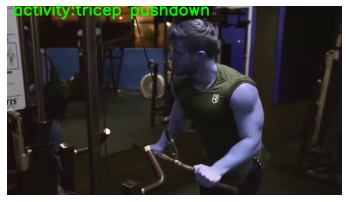

In [23]:
random_classes_names = random.choice(os.listdir('/content/gdrive/MyDrive/workout_exercises_recognition/workoutexercises-dataset_videos/workout'))
random_file = random.choice(os.listdir(f'/content/gdrive/MyDrive/workout_exercises_recognition/workoutexercises-dataset_videos/workout/{random_classes_names}'))
print(f'{random_classes_names}/{random_file}')

# Construct the input video file path
input_video_file_path = f'/content/gdrive/MyDrive/workout_exercises_recognition/workoutexercises-dataset_videos/workout/{random_classes_names}/{random_file}'

# Initialize video input
video_capture = cv2.VideoCapture(input_video_file_path)
writer = None
H, W = None, None
Q = deque(maxlen=128)
n = 0

# Loop through each frame in the video
while True:
    # count the frame
    n += 1
    
    # predict every 5 frame (1, 6, 11, ... etc)
    if n % 5 != 1:
        continue
    
    # read a frame
    success, frame = video_capture.read()
    
    # if frame not read properly then break the loop
    if not success:
        break
    
    # get frame dimensions
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    
    # clone the frame for the output then preprocess the frame for the prediction
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, img_size).astype("float32")
        
    predictions = workout_model.predict(np.expand_dims(frame, axis=0))[0]
    Q.append(predictions)
    
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = labels[i]
    
    text = 'activity:{}'.format(label)
    cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 10)
    
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"XVID")
        writer = cv2.VideoWriter('output.avi', fourcc, 30, (W, H), True)
        
    writer.write(output)
    
    plt.imshow(output)
    plt.axis('off')
    
    # break the loop if prediction > 90% and video already more than 2 seconds (60 frame)
    if results[i] >= 0.9 and n >= 60:
        break

print(text)
print(f'confidence: {results[i]}')
writer.release()
video_capture.release()